In [5]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'{device} is available.')

cuda is available.


In [7]:
batch_size = 128
num_clusters = 10
latent_size = 10

trainset = torchvision.datasets.MNIST('data', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('data', download=True, train=False, transform=transforms.ToTensor())

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [35]:
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        
        return x.view(batch_size, -1)
    
class DeFlatten(nn.Module):
    def __init__(self, k) -> None:
        super().__init__()
        self.k = k

    def forward(self, x):
        batch_size, vector_size = x.shape
        img_size = int((vector_size // self.k) ** 0.5)

        return x.view(batch_size, self.k, img_size, img_size)
    
class Kmeans(nn.Module):
    def __init__(self, num_clusters, latent_size) -> None:
        super().__init__()
        self.num_clusters = num_clusters
        self.centroids = nn.Parameter(torch.rand(num_clusters, latent_size).to(device))

    def get_nearest_distance(self, a, b):
        return torch.argmin(torch.sum((a - b) ** 2, dim=1), dim=0)
    
    def forward(self, x):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(self.num_clusters, -1)
            assign = self.get_nearest_distance(h, self.centroids)
            y_assign.append(assign.item())

        return y_assign, self.centroids[y_assign]
        

In [36]:
class Encoder(nn.Module):
    def __init__(self, latent_size) -> None:
        super().__init__()
        
        k = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, k, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(k, 2 * k, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(2 * k, 4 * k, 3, stride=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(1024, latent_size),
            nn.ReLU()
        )
        

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, latent_size) -> None:
        super().__init__()

        k = 16
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU(),
            DeFlatten(4 * k),
            nn.ConvTranspose2d(4 * k, 2 * k, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * k, k, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(x)

In [52]:
def calc_cluster_acc(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        D = max(y_pred.max(), y_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(y_pred.size):
            w[y_pred[i], y_true[i]] += 1
        ind = linear_sum_assignment(w.max() - w)

        return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

def evaluation(test_loader, encoder, kmeans, device):    
    predictions = []
    actual = []
    with torch.inference_mode():
        for images, labels in test_loader:
            inputs, labels = images.to(device), labels.to(device)
            latent_variables = encoder(inputs)
            y_preds, _ = kmeans(latent_variables)

            predictions += y_preds
            actual += labels.cpu().tolist()

    return calc_cluster_acc(actual, predictions)

In [46]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)

In [47]:
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(kmeans.parameters()),
    lr=1e-3
) 

In [48]:
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05

for ep in range(300):
    if ep > T1 and ep < T2:
        alpha = lam * (ep - T1) / (T2 - T1)
    elif ep >= T2:
        alpha = lam
    else:
        alpha = lam / (T2 - T1)

    running_loss = 0.0
    for images, _ in train_loader:
        inputs = images.to(device)
        latent_variables = encoder(inputs)
        _, centroids = kmeans(latent_variables.detach())
        outputs = decoder(latent_variables)

        l_rec = criterion1(inputs, outputs)
        l_clt = criterion2(latent_variables, centroids)
        loss = l_rec + alpha * l_clt
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    if ep % 10 == 0:
        test_acc = evaluation(test_loader, encoder, kmeans, device)
        print(f'[{ep}] Train loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.3f}')

    if avg_loss < ls:
        ls = avg_loss
        torch.save(encoder.state_dict(), 'models/dkm_en.pth')
        torch.save(decoder.state_dict(), 'models/dkm_de.pth')
        torch.save(kmeans.state_dict(), 'models/dkm_clt.pth')

[0] Train loss: 0.0914, Test Accuracy: 0.181
[10] Train loss: 0.0237, Test Accuracy: 0.116
[20] Train loss: 0.0212, Test Accuracy: 0.206
[30] Train loss: 0.0203, Test Accuracy: 0.262
[40] Train loss: 0.0197, Test Accuracy: 0.404
[50] Train loss: 0.0194, Test Accuracy: 0.448
[60] Train loss: 0.0191, Test Accuracy: 0.538
[70] Train loss: 0.0189, Test Accuracy: 0.610
[80] Train loss: 0.0188, Test Accuracy: 0.696
[90] Train loss: 0.0186, Test Accuracy: 0.800
[100] Train loss: 0.0185, Test Accuracy: 0.778
[110] Train loss: 0.0184, Test Accuracy: 0.776
[120] Train loss: 0.0183, Test Accuracy: 0.778
[130] Train loss: 0.0182, Test Accuracy: 0.781
[140] Train loss: 0.0181, Test Accuracy: 0.779
[150] Train loss: 0.0181, Test Accuracy: 0.787
[160] Train loss: 0.0180, Test Accuracy: 0.784
[170] Train loss: 0.0179, Test Accuracy: 0.782
[180] Train loss: 0.0179, Test Accuracy: 0.783
[190] Train loss: 0.0178, Test Accuracy: 0.785
[200] Train loss: 0.0178, Test Accuracy: 0.788
[210] Train loss: 0.0178

In [49]:
encoder.load_state_dict(torch.load('models/dkm_en.pth'))
decoder.load_state_dict(torch.load('models/dkm_de.pth'))
kmeans.load_state_dict(torch.load('models/dkm_clt.pth'))

<All keys matched successfully>

Input images


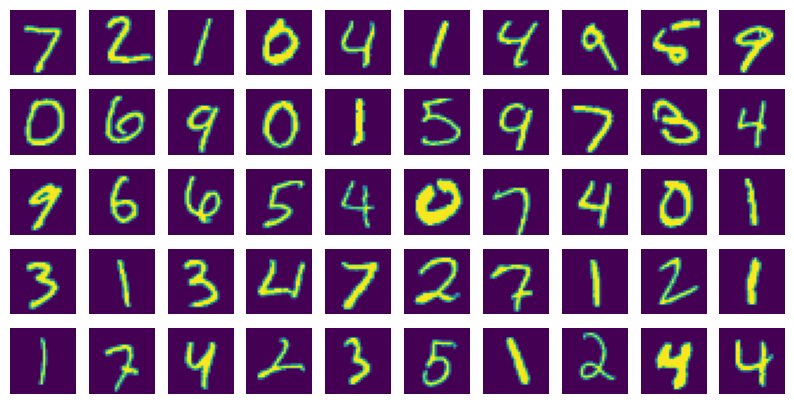

Reconstructed images


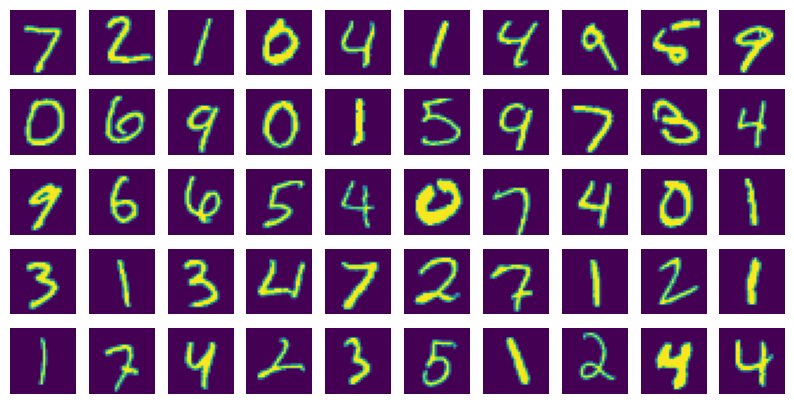

In [50]:
with torch.inference_mode():
    for images, _ in test_loader:
        inputs = images.to(device)
        latent_variables = encoder(inputs)
        outputs = decoder(latent_variables)

        input_samples = inputs.permute(0, 2, 3, 1).cpu().numpy()
        reconstructed_samples = inputs.permute(0, 2, 3, 1).cpu().numpy()
        break
    
columns = 10
rows = 5
print('Input images')
fig = plt.figure(figsize=(columns, rows))
for i in range(1, columns * rows + 1):
    img = input_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
plt.show()

print('Reconstructed images')
fig = plt.figure(figsize=(columns, rows))
for i in range(1, rows * columns + 1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
plt.show()

In [70]:
predictions = []
actual = []
latent_features = []
with torch.inference_mode():
    for images, labels in test_loader:
        inputs = images.to(device)
        labels = labels.to(device)
        latent_variables = encoder(inputs)
        y_preds, _ = kmeans(latent_variables)

        predictions += y_preds
        latent_features += latent_variables.cpu().tolist()
        actual += labels.cpu().tolist()

print(calc_cluster_acc(actual, predictions))

0.7825


In [72]:
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(latent_features)))
actual = np.array(actual)

In [74]:
cluster.shape, actual.shape

((10000, 2), (10000,))

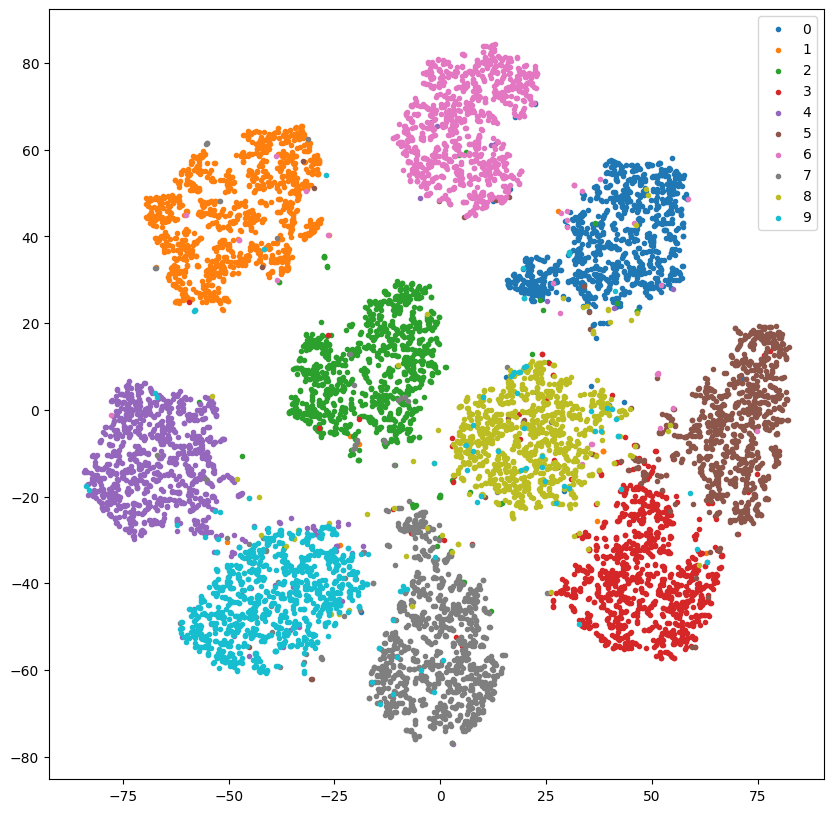

In [73]:
plt.figure(figsize=(10, 10))
mnist = range(10)
for i, label in zip(range(10), mnist):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=str(label))
plt.legend()
plt.show()